## Doubly Robust CATE Estimators

In [470]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor


# DoWhy imports 
import dowhy
from dowhy import CausalModel

# EconML imports
from econml.dr import DRLearner, ForestDRLearner
from econml.dml import LinearDML, CausalForestDML, SparseLinearDML, NonParamDML
from econml.inference import BootstrapInference
from econml.cate_interpreter import SingleTreeCateInterpreter

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Custom DoWhy helper functions
from pathlib import Path
import os
import sys
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [315]:
# I/O Stuff
DATA_FILENAME = "csdh_burr.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [316]:
class RegWrapper:
    def __init__(self, classifier):
        self.classifier = classifier
    def fit(self, X, y, **kwargs):
        return self.classifier.fit(X, y, **kwargs)
    def predict(self, X):
        return self.classifier.predict_proba(X)[:, 1]

---
## 0. Naïve ATE Estimation (no causal inference)

In [317]:
# DOCTOR DAG features
doc_features = ['age', 'stroke', 'ihd', 'metalvalve', 'antiplatelet', 'warfarin', 'hospital',
                'thickness_sum', 'density', 'optype', 'membranes', 'burrhole_num', 'bedrest',
                'drain', 'recurrence']
csdh = csdh[doc_features]
            
# Categorical type conversion
categorical_features = ['optype', 'hospital', 'bedrest', 'density',  'burrhole_num', 'bedrest']

binary_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'recurrence',
                   'drain', 'warfarin', 'membranes']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes
    
for feature in binary_features:
    csdh[feature] = csdh[feature].astype(int)

In [318]:
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.08374644024891888


---
## CATE Estimation begins...

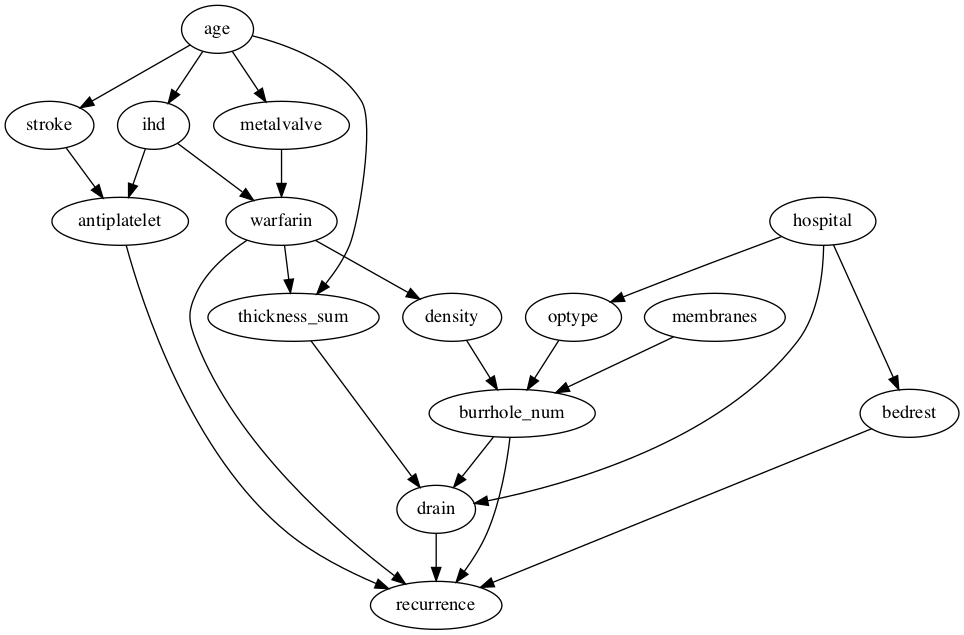

In [319]:
doc_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
doc_model.view_model()
display(Image(filename="causal_model.png"))

In [320]:
csdh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            594 non-null    int64
 1   stroke         594 non-null    int64
 2   ihd            594 non-null    int64
 3   metalvalve     594 non-null    int64
 4   antiplatelet   594 non-null    int64
 5   warfarin       594 non-null    int64
 6   hospital       594 non-null    int8 
 7   thickness_sum  594 non-null    int64
 8   density        594 non-null    int8 
 9   optype         594 non-null    int8 
 10  membranes      594 non-null    int64
 11  burrhole_num   594 non-null    int8 
 12  bedrest        594 non-null    int8 
 13  drain          594 non-null    int64
 14  recurrence     594 non-null    int64
dtypes: int64(10), int8(5)
memory usage: 49.4 KB


In [505]:
confounders = ['hospital', 'antiplatelet', 'metalvalve', 'thickness_sum', 'ihd',
               'bedrest', 'optype','warfarin', 'age', 'stroke', 'density', 'membranes']
conditional_features = ['burrhole_num']


T = csdh['drain'].values
Y = csdh['recurrence'].values
X = csdh[conditional_features].values
W = csdh[confounders].values

In [506]:
model_propensity = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.8, tree_method='exact',
                               validate_parameters=1, verbosity=None)

model_regression = XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.03,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=1,
                               monotone_constraints='()', n_estimators=151,
                               n_jobs=16, num_parallel_tree=1, random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None)

In [507]:
# initiate an EconML cate estimator
est = CausalForestDML(model_y=RegWrapper(model_regression), 
                      model_t=model_propensity,
                      random_state=100,
                      discrete_treatment=True,
                      categories=[0,1])

In [498]:
# initiate an EconML cate estimator
est = NonParamDML(model_y=RegWrapper(model_regression), 
                  model_t=model_propensity,
                  model_final=GradientBoostingRegressor(),
                  random_state=100,
                  discrete_treatment=True,
                  categories=[0,1])

In [516]:
# initiate an EconML cate estimator
est = LinearDML(model_y=RegWrapper(model_regression, 
                model_t=model_propensity,
                random_state=100,
                featurizer=PolynomialFeatures(degree=1, include_bias=False),
                fit_cate_intercept=False,
                discrete_treatment=True,
                categories=[0,1])

TypeError: __init__() got an unexpected keyword argument 'model_final'

In [508]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, 
                       outcome_names=["recurrence"], 
                       treatment_names=["drain"], 
                       feature_names=conditional_features,
                       confounder_names=confounders,
                       cache_values=True,
                       graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))

[13:47:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:47:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

In [509]:
est_dw.score_

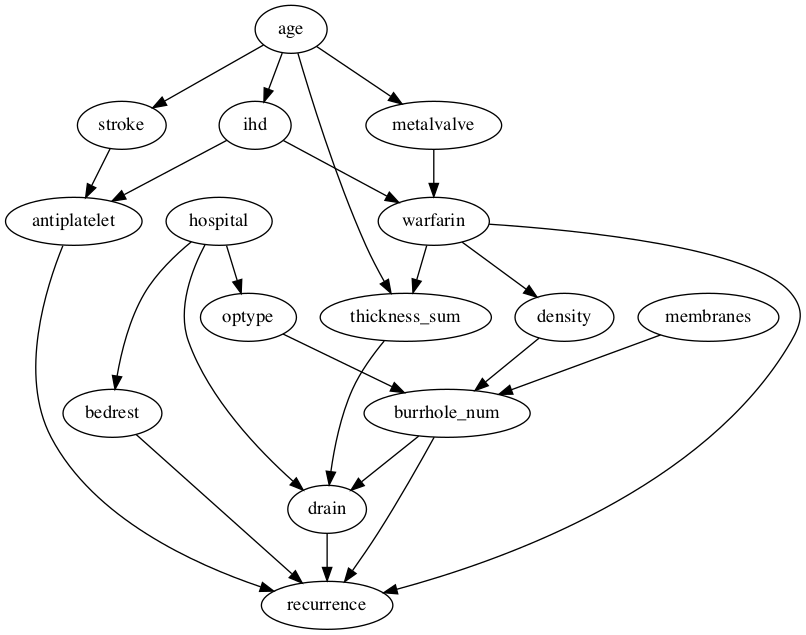

In [514]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model()

In [511]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|warfarin,density,bedrest,thickness_sum,age,mem
d[drain]                                                                      

                                                                        
branes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,warfarin,density,bedrest,thickness_sum,age,membranes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital,U) = P(recurrence|drain,warfarin,density,bedrest,thickness_sum,age,membranes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: 

In [512]:
drlearner_estimate = est_dw.estimate_
print(drlearner_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|warfarin,density,bedrest,thickness_sum,age,mem
d[drain]                                                                      

                                                                        
branes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,warfarin,density,bedrest,thickness_sum,age,membranes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital,U) = P(recurrence|drain,warfarin,density,bedrest,thickness_sum,age,membranes,burrhole_num,metalvalve,ihd,antiplatelet,optype,stroke,hospital)

## Realized estimand
b: recurrence~drain+war

In [513]:
# Get the final coefficient and intercept summary
est_dw.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate               
================================================================
mean_point stderr_mean zstat  pvalue ci_mean_lower ci_mean_upper
----------------------------------------------------------------
    -0.071       0.048 -1.475   0.14        -0.151         0.008
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.016          -0.112          -0.067
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.051         -0.154          0.003
       Doubly Robust ATE on Training Data Results       
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATE          0.276  1.817 0.152  0.879   -2.713    3.264
    Doubly Robust ATT(T=0) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          2.446 11.357 0.215  0.829  -16.234   21.126
     Doubly Robust ATT(T=1) on Training Data Results     
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATT         -0.138  0.034 -4.025    0.0   -0.194   -0.081
---------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

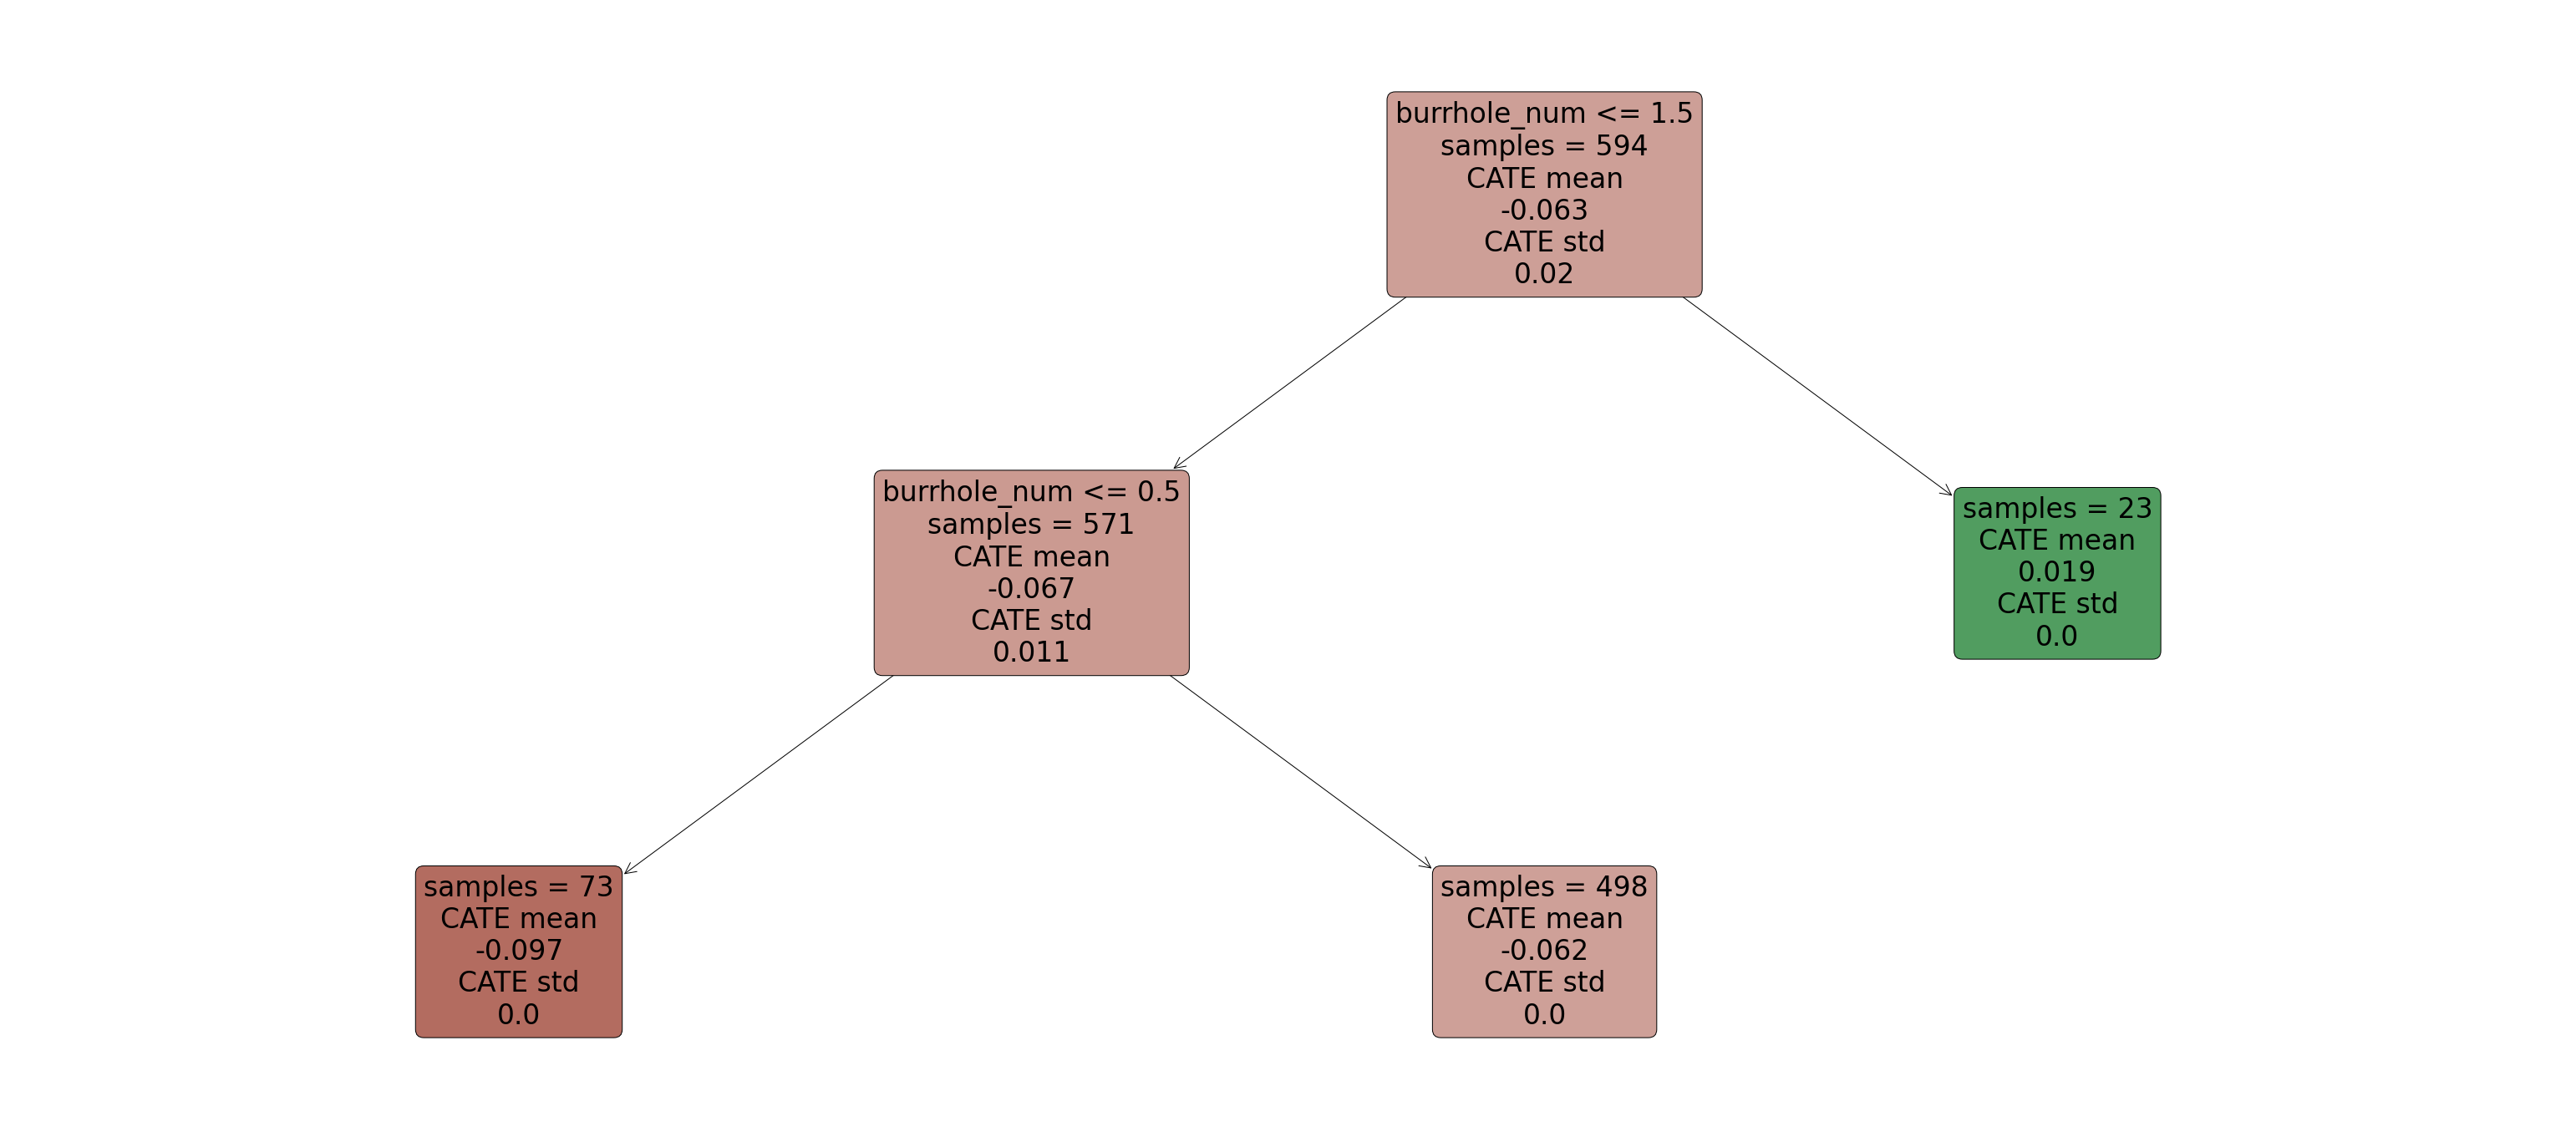

In [494]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=False, max_depth=4, min_samples_leaf=10)
intrp.interpret(est_dw, X)
plt.figure(figsize=(55, 25))
intrp.plot(feature_names=conditional_features, fontsize=33)

---
# Treatment Investigation

In [22]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, Z=Z, X=X, W=W, outcome_names=["recurrence"], treatment_names=["drain"], feature_names=['antiplatelet', 'thickness_sum', 'stroke', 'ihd', 'metalvalve', 'age'],
                       graph='../causal_graphs/cate_dag.dot'.replace("\n", " "),
               confounder_names=confounder_names, inference="statsmodels")

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


TypeError: unhashable type: 'list'

In [122]:
csdh[csdh['burrhole_num'].isna()].index

Int64Index([  5,  17,  24,  29,  33,  37,  42,  57,  64,  65,
            ...
            690, 691, 696, 697, 703, 711, 720, 722, 724, 728],
           dtype='int64', length=151)

In [123]:
csdh_burr = csdh.drop(csdh[csdh['burrhole_num'].isna()].index)

In [124]:
# Mapping bedrest to categorical variable
csdh_burr['bedrest'] = csdh_burr['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})

In [125]:
sum(csdh_burr['recurrence']==1)

In [126]:
sum(csdh_burr['recurrence']==0)

In [127]:
T = csdh_burr['drain'].values
Y = csdh_burr['recurrence'].values
X = csdh_burr[['burrhole_num', 'optype', 'bedrest']].values

confounder_names = ['platelet', 'hospital', 'antiplatelet', 'stroke', 'ihd',
                    'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum']
W = csdh_burr[confounder_names].values

In [128]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingClassifier(), 
          model_t=GradientBoostingClassifier(),
                random_state=1,
                fit_cate_intercept=False,
          featurizer=PolynomialFeatures(degree=1, include_bias=False),
          discrete_treatment=True,
                categories=[0,1]
         )

In [129]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["recurrence"], treatment_names=["drain"], feature_names=['burrhole_num', 'optype', 'bedrest'],
                       graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "),
               confounder_names=confounder_names, inference="statsmodels")

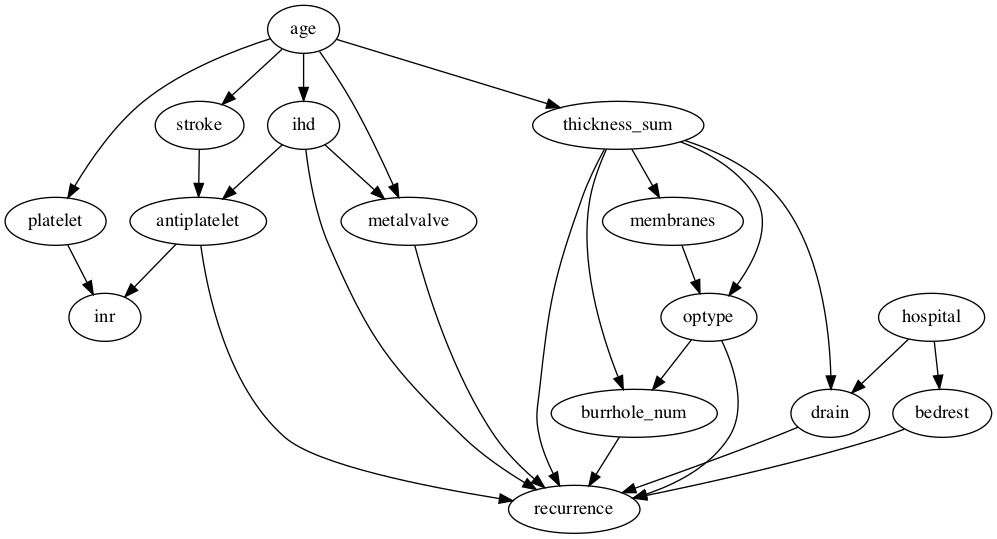

In [130]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model()

In [131]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such va

In [132]:
forestdml_estimate = est_dw.estimate_
print(forestdml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

## Realized estimand
b: recurrence~drain+platelet+membranes+inr+

In [133]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=['burrhole_num', 'optype', 'bedrest'])

CATE Intercept Results:  No intercept was fitted!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
burrhole_num,-0.015,0.043,-0.35,0.727,-0.086,0.056
optype,-0.083,0.068,-1.228,0.219,-0.194,0.028
bedrest,0.01,0.038,0.251,0.801,-0.053,0.072


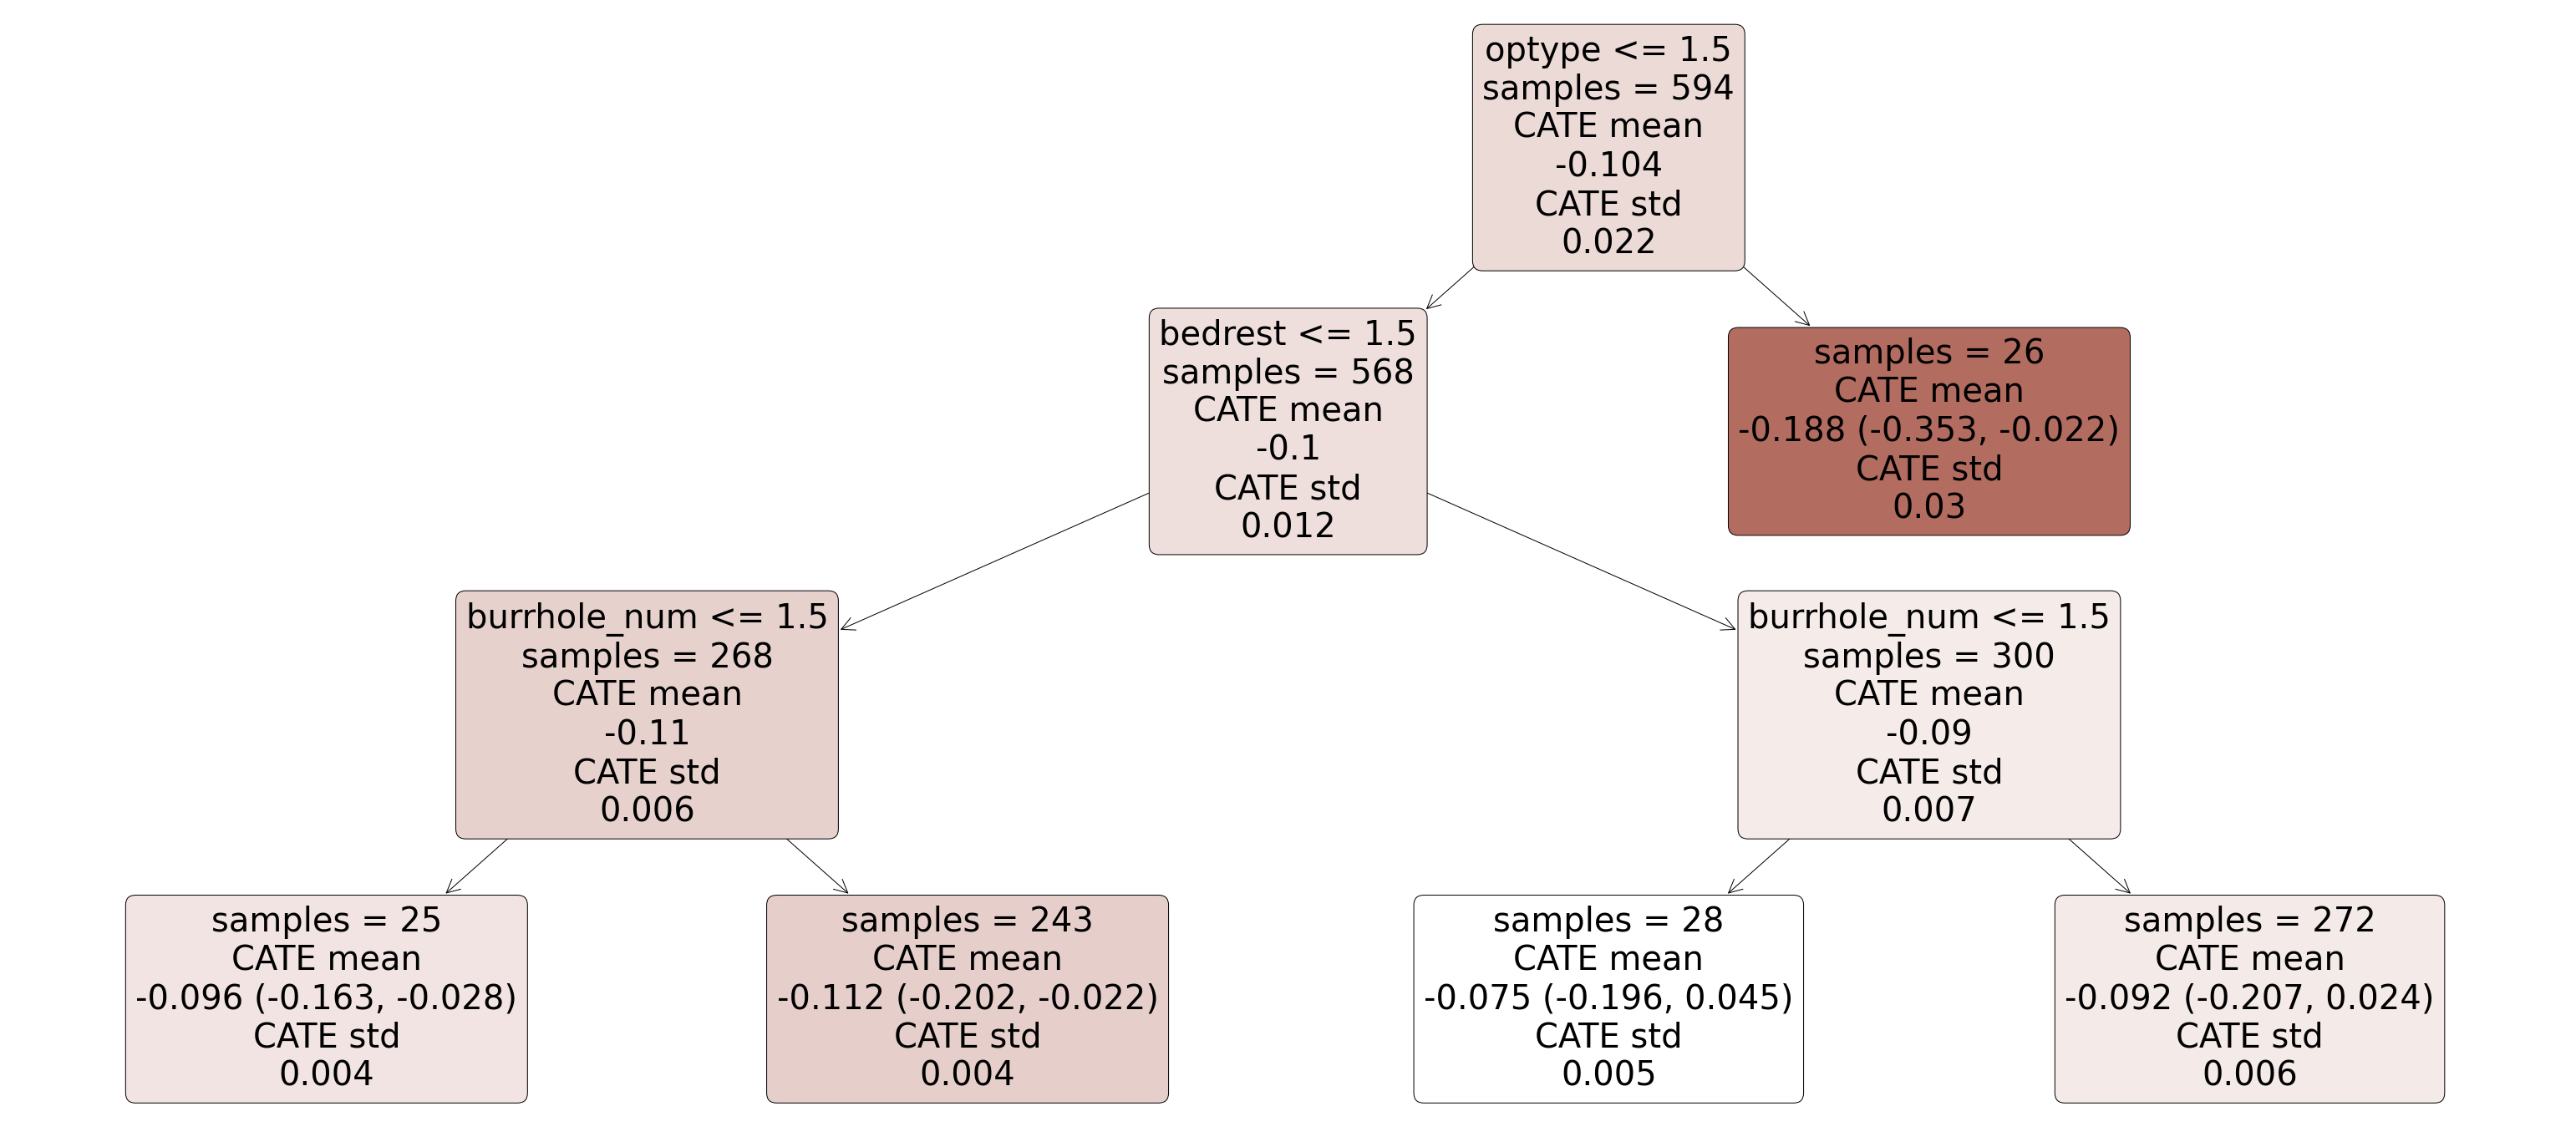

In [137]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(est_dw, X)
plt.figure(figsize=(55, 25))
intrp.plot(feature_names=['burrhole_num', 'optype', 'bedrest'], fontsize=40)

In [223]:
T = csdh_burr['drain'].values
Y = csdh_burr['recurrence'].values
X = csdh_burr[['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum']].values
W = csdh_burr[['hospital', 'stroke', 'platelet']].values

In [224]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingClassifier(), model_t=GradientBoostingClassifier(),
                random_state=100,
                fit_cate_intercept=True,
                featurizer=PolynomialFeatures(degree=1, include_bias=False),
                discrete_treatment=True,
                categories=[0,1])

In [225]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W,
                       outcome_names=["recurrence"], 
                       treatment_names=["drain"],
                       confounder_names = ['hospital', 'stroke', 'platelet'],
                       feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum'],
                       graph='../causal_graphs/treatment_dag.dot'.replace("\n", " "),
                       inference="statsmodels")

In [226]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such va

In [227]:
forestdml_estimate = est_dw.estimate_
print(forestdml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|platelet,membranes,inr,thickness_sum,bedrest,s
d[drain]                                                                      

                                                                    
troke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet))
                                                                    
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet,U) = P(recurrence|drain,platelet,membranes,inr,thickness_sum,bedrest,stroke,metalvalve,hospital,optype,age,ihd,burrhole_num,antiplatelet)

## Realized estimand
b: recurrence~drain+platelet+membranes+inr+

In [230]:
# Get the final coefficient and intercept summary
est_dw.summary(feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'inr', 'thickness_sum'])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
burrhole_num,0.078,0.104,0.753,0.452,-0.093,0.249
optype,0.084,0.046,1.808,0.071,0.008,0.16
bedrest,0.003,0.03,0.099,0.921,-0.047,0.053
antiplatelet,0.13,0.106,1.223,0.221,-0.045,0.305
ihd,-0.134,0.106,-1.272,0.203,-0.308,0.039
metalvalve,0.02,0.192,0.105,0.916,-0.295,0.335
age,-0.002,0.003,-0.648,0.517,-0.006,0.003
membranes,-0.028,0.1,-0.28,0.779,-0.192,0.136
inr,0.487,0.242,2.009,0.045,0.088,0.885
thickness_sum,0.0,0.007,0.055,0.956,-0.011,0.012


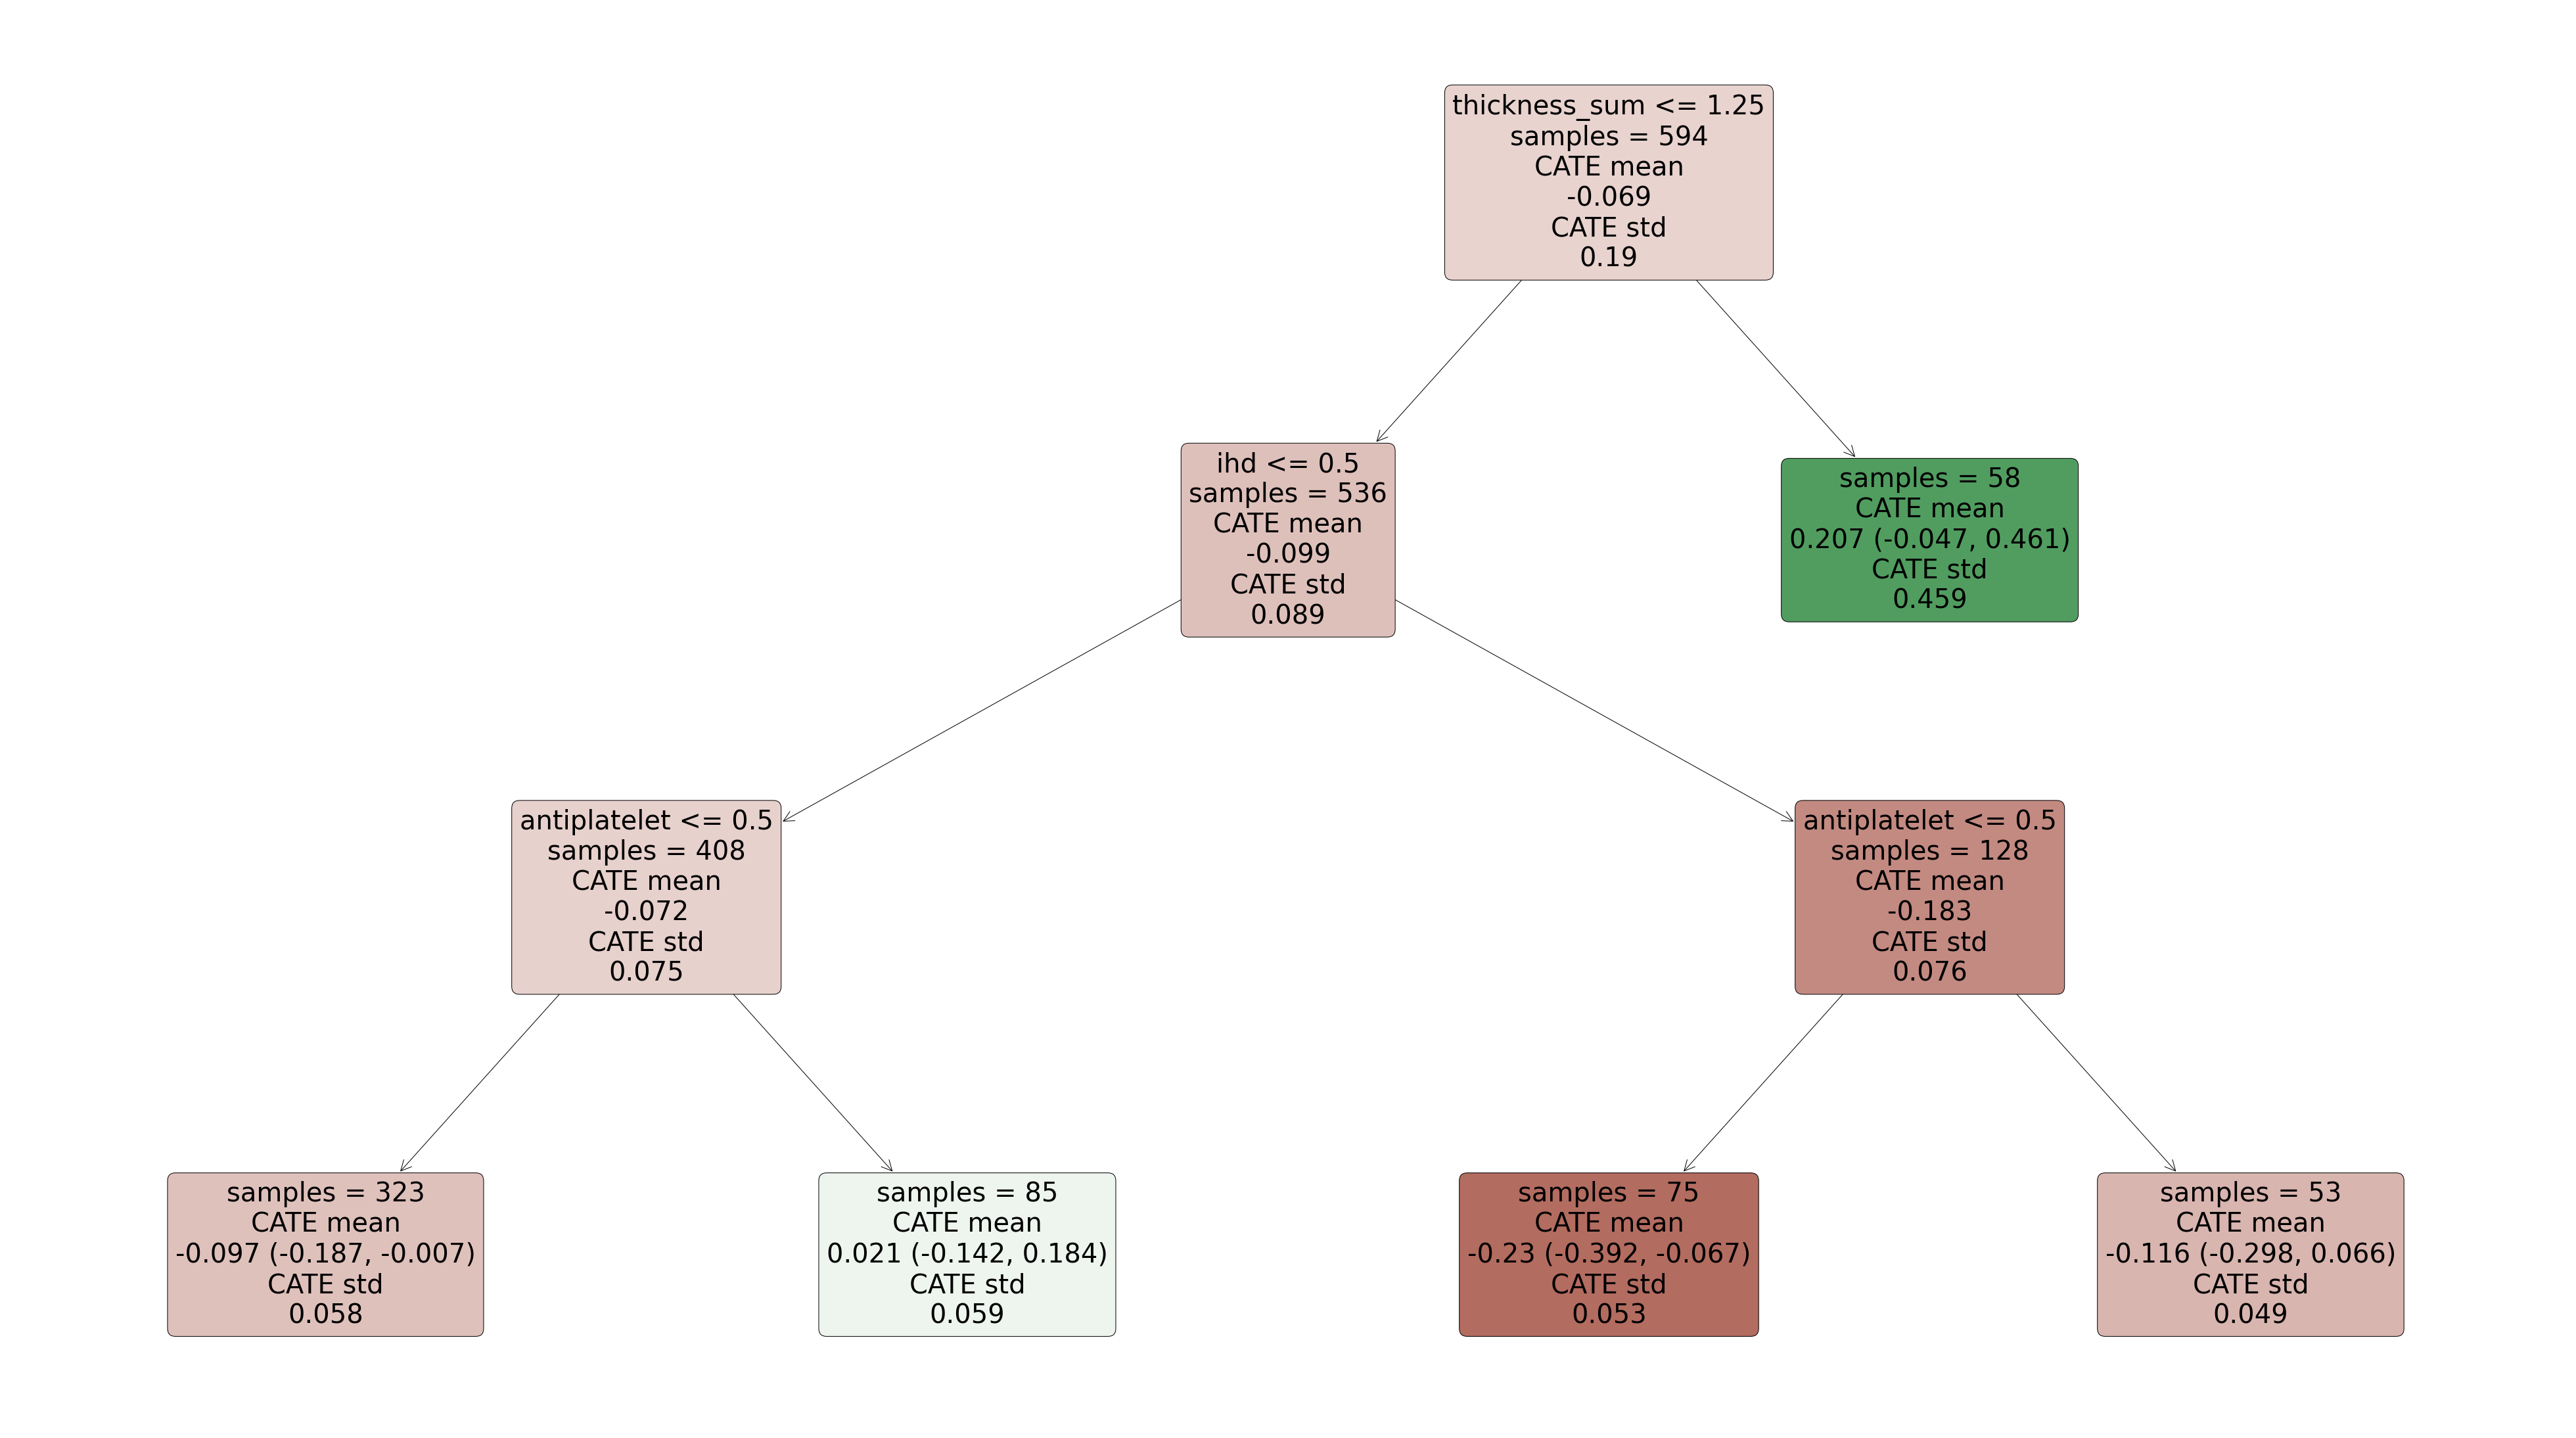

In [236]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=50)
intrp.interpret(est_dw, X)
plt.figure(figsize=(70, 40))
intrp.plot(feature_names=['burrhole_num', 'optype', 'bedrest', 'antiplatelet', 'ihd', 'metalvalve', 'age', 'membranes', 'thickness_sum'], fontsize=40)

In [237]:
est_dw.score_